In [49]:
from scipy.io import loadmat
import proplot as pplt
import pandas as pd
import numpy as np
import sys
sys.path.append('../../drifter')
from importlib import reload
import utilities.cleaning as clean
import utilities.interpolation as interp

clean = reload(clean)
interp = reload(interp)

Gap sizes: At the beginning of this buoy's time series, there's a few huge gaps that suggest either errors or that the buoy was tested en route to the site. 

In [16]:
speed = clean.compute_speed(test.copy().where(~(test.flag_date | test.flag_dup)))['speed']

In [32]:
test['speed'] = speed
data = test.dropna().loc[:, ['date', 'flag_date', 'flag_dup', 'latitude', 'longitude', 'speed']]

In [58]:
# Alternate test: checking MOSAiC data
df['date']

0    2020-01-01 00:00:00
1    2020-01-01 00:30:00
2    2020-01-01 01:00:00
3    2020-01-01 01:00:00
4    2020-01-01 02:00:00
5    2020-01-01 02:30:00
6    2020-01-01 02:30:30
7    2020-01-01 03:30:00
8    2020-01-01 04:00:00
9    2020-01-01 03:31:00
10   2020-01-01 05:00:00
11   2020-01-01 05:30:00
12   2020-01-01 06:00:00
Name: date, dtype: datetime64[ns]

In [103]:
clean = reload(clean)
%run ../tests/basic_functions.py

In [100]:
df.loc[8:, 'date'] += pd.to_timedelta('6H')
df.loc[9:, 'date'] += pd.to_timedelta('6H')
df['gap_flag'] = clean.check_gaps(df, date_col='date', threshold_gap='2H', threshold_segment=1)
df

,date,latitude,longitude,date_flag,pos_flag,gap_flag
0,2020-01-01 00:00:00,65.0,-100.000000,False,False,False
1,2020-01-01 00:30:00,67.5,-76.583333,False,False,False
2,2020-01-01 01:00:00,70.0,-53.166667,False,False,False
3,2020-01-01 01:00:00,72.5,-29.750000,True,False,False
4,2020-01-01 02:00:00,75.0,-6.333333,False,False,False
5,2020-01-01 02:30:00,77.5,17.083333,False,False,False
6,2020-01-01 02:30:30,82.5,40.500000,True,False,False
7,2020-01-01 03:30:00,82.5,63.916667,False,False,False
8,2020-01-01 10:00:00,85.0,63.916667,False,False,True
9,2020-01-01 15:31:00,70.0,-53.166667,True,True,False


In [207]:
clean_data = loadmat('../../data/JennyProcessed/IABP2010.mat')['IABP2010']

In [208]:
# Pick an index, there's going to be some issues. Test_duplicates is idx=0, test_speed is idx=20.
idx = 0
ndata = {n: clean_data[n][0] for n in clean_data.dtype.names}
buoy0 = pd.DataFrame({c: np.concatenate(ndata[c][idx]) for c in clean_data.dtype.names[1:]})
buoy0['id'] = buoy0['id'].astype(int)
buoy0['date'] = pd.Series([pd.to_datetime(str(y) + '-01-01 00:00') + pd.to_timedelta(x, unit='days') 
              for x, y in zip(buoy0.yday, buoy0.year)]).round('1min')
buoy0.rename({'lat': 'latitude',
              'lon': 'longitude'}, axis=1, inplace=True)
buoy0.to_csv('../data/test_speed.csv')

In [218]:
test.loc[test.flag_dup].head(10).loc[:, ['year', 'hour', 'min', 'flag_dup']]

,year,hour,min,flag_dup
1,2010,14,2,True
4,2011,14,0,True
5,2011,15,0,True
6,2011,16,0,True
7,2011,17,0,True
8,2011,18,0,True
9,2011,19,0,True
10,2011,20,0,True
11,2011,21,0,True
12,2011,22,0,True


# Testing analysis pathway for MOSAiC buoys


In [167]:
# Folder with the drift tracks from 
# the Arctic Data Center (Bliss et al. 2021)
# https://arcticdata.io/catalog/view/urn%3Auuid%3A2b859a39-cada-4147-819a-dc222f6f89a3
dataloc = '../../data/adc_dn_tracks/'

# Maximum gap in hours for the interpolation algorithm
max_dt = 2

# Pad for interpolation, so that the first and last values aren't missing.
margin = pd.to_timedelta('6H')

# Optional: focus in on only a portion of the tracks
begin = '2019-10-15 00:00'
end = '2022-01-01 00:00'

# Read in the files, including the metadata file
files = os.listdir(dataloc)
files = [f for f in files if f.split('.')[-1] == 'csv']
files = [f for f in files if f.split('_')[0] != 'DN']

metadata = pd.read_csv(dataloc + 'DN_buoy_list_v2.csv')
metadata['filename'] = ['_'.join([x, str(y), z]) for 
                        x, y, z in zip(metadata['DN Station ID'],
                                       metadata['IMEI'],
                                       metadata['Sensor ID'])]
    
file_present = np.array([f + '.csv' in files for f in metadata.filename])
metadata = metadata.loc[file_present].copy()
metadata.set_index('Sensor ID', inplace=True)


buoy_data = {}
for file in files:
    buoy_data[file.replace('.csv', '').split('_')[-1]] = pd.read_csv(dataloc + file,
                                            index_col='datetime', parse_dates=True)



# Read in specific buoy

In [169]:
for buoy in buoy_data:
    buoy_data[buoy]['check_dates'] = clean.check_dates(buoy_data[buoy], date_index=True)
    buoy_data[buoy]['check_dups'] = clean.flag_duplicates(buoy_data[buoy], date_index=True)
    buoy_data[buoy]['check_speed'] = clean.check_speed(buoy_data[buoy], '5H', 4, True, method='neighbor')

In [222]:
# Checks
test_df = pd.DataFrame(
    [['2019R9', '2020-04-23 11:01:09', 'check_speed', True],
     ['2019R9', '2020-05-17 01:02:20', 'check_speed', True],
     ['2020P171','2020-12-13 00:04:00', 'check_speed', True],
     ['2020P171', '2021-01-08 20:04:01', 'check_speed', True],
     ['2020P171', '2021-01-08 16:04:02', 'check_speed', True],
     ['2019P178', '2021-01-21 13:00:28', 'check_speed', True],
     ['2019P142', '2020-04-04 14:30:00', 'check_speed', True],
     ['2019P142', '2020-05-25 01:00:00', 'check_speed', True], 
      ['2019P142', '2020-07-23 00:59:59', 'check_speed', True]],
    columns=['buoy_id', 'date', 'check_var', 'true_val'])
test_df['check_val'] = np.nan
buoy = '2019R9'
for idx in test_df.index:
    buoy = test_df.loc[idx, 'buoy_id']
    if buoy in buoy_data:    
        date = test_df.loc[idx, 'date']
        var = test_df.loc[idx, 'check_var']
        test_df.loc[idx, 'check_val'] = buoy_data[buoy].loc[date, var]

In [223]:
test_df

,buoy_id,date,check_var,true_val,check_val
0,2019R9,2020-04-23 11:01:09,check_speed,True,True
1,2019R9,2020-05-17 01:02:20,check_speed,True,False
2,2020P171,2020-12-13 00:04:00,check_speed,True,False
3,2020P171,2021-01-08 20:04:01,check_speed,True,True
4,2020P171,2021-01-08 16:04:02,check_speed,True,True
5,2019P178,2021-01-21 13:00:28,check_speed,True,NaN


In [131]:
buoy_df = pd.read_csv(dataloc + metadata.loc['2019R9', 'filename'] + '.csv', index_col='datetime', parse_dates=True)
buoy_df2 = pd.read_csv(dataloc + metadata.loc['2019S93', 'filename'] + '.csv', index_col='datetime', parse_dates=True)
buoy_df3 = pd.read_csv(dataloc + metadata.loc['2019P142', 'filename'] + '.csv', index_col='datetime', parse_dates=True)

In [185]:
for buoy in buoy_data:
    buoy_df = buoy_data[buoy].copy()
    clean.compute_speed(buoy_df, date_index=True, difference='centered')
    buoy_data[buoy]['x'] = buoy_df['x']
    buoy_data[buoy]['y'] = buoy_df['y']

In [175]:
buoy = '2019S93'
buoy_data[buoy][['check_dates', 'check_dups', 'check_speed']].sum()

check_dates      0
check_dups     208
check_speed     92
dtype: int64

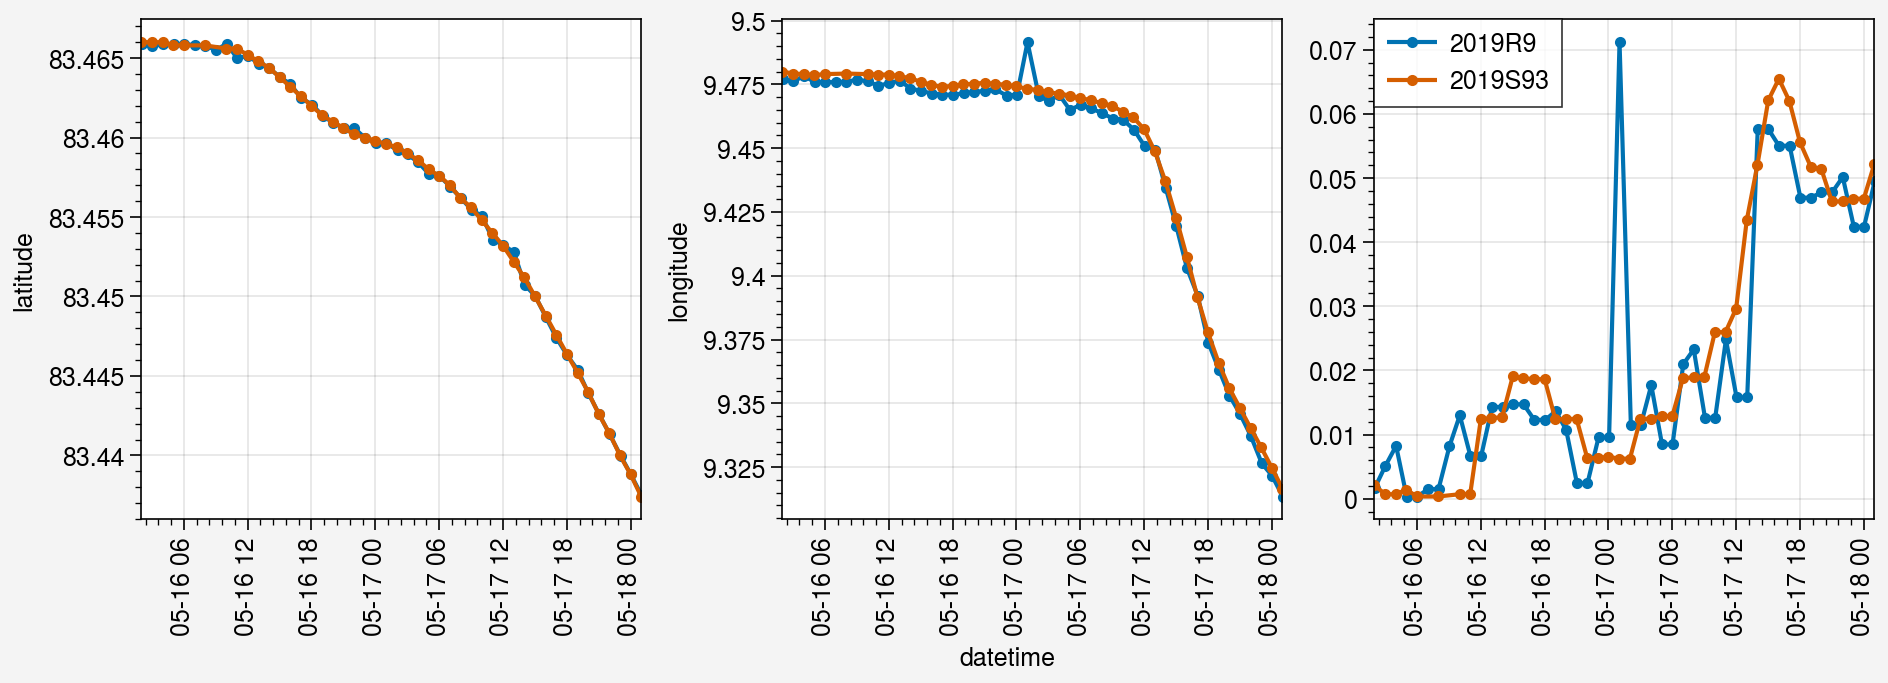

In [204]:
margin = pd.to_timedelta('24H')
buoy_df = buoy_data['2019R9']
buoy_df2 = buoy_data['2019S93']
fwd_speed = clean.compute_speed(buoy_df.copy(), date_index=True, difference='forward')['speed']   
bwd_speed = clean.compute_speed(buoy_df.copy(), date_index=True, difference='backward')['speed']   
speed = pd.DataFrame({'b': bwd_speed, 'f': fwd_speed}).min(axis=1)

fwd_speed2 = clean.compute_speed(buoy_df2.copy(), date_index=True, difference='forward')['speed']   
bwd_speed2 = clean.compute_speed(buoy_df2.copy(), date_index=True, difference='backward')['speed']   
speed2 = pd.DataFrame({'b': bwd_speed2, 'f': fwd_speed2}).min(axis=1)

date = pd.to_datetime('2020-05-17 01:02:20')
fig, ax = pplt.subplots(ncols=3, sharey=False)
for axis, var in zip(ax, ['latitude', 'longitude']):
    axis.plot(buoy_df.loc[slice(date - margin, date + margin)][var], marker='.')
    axis.plot(buoy_df2.loc[slice(date - margin, date + margin)][var], marker='.')
    
ax[2].plot(speed[slice(date - margin, date + margin)], marker='.', label='2019R9')
ax[2].plot(speed2[slice(date - margin, date + margin)], marker='.', label='2019S93')
ax[2].legend(ncols=1)

In [226]:
# buoy_df.loc[buoy_df.check_dups]

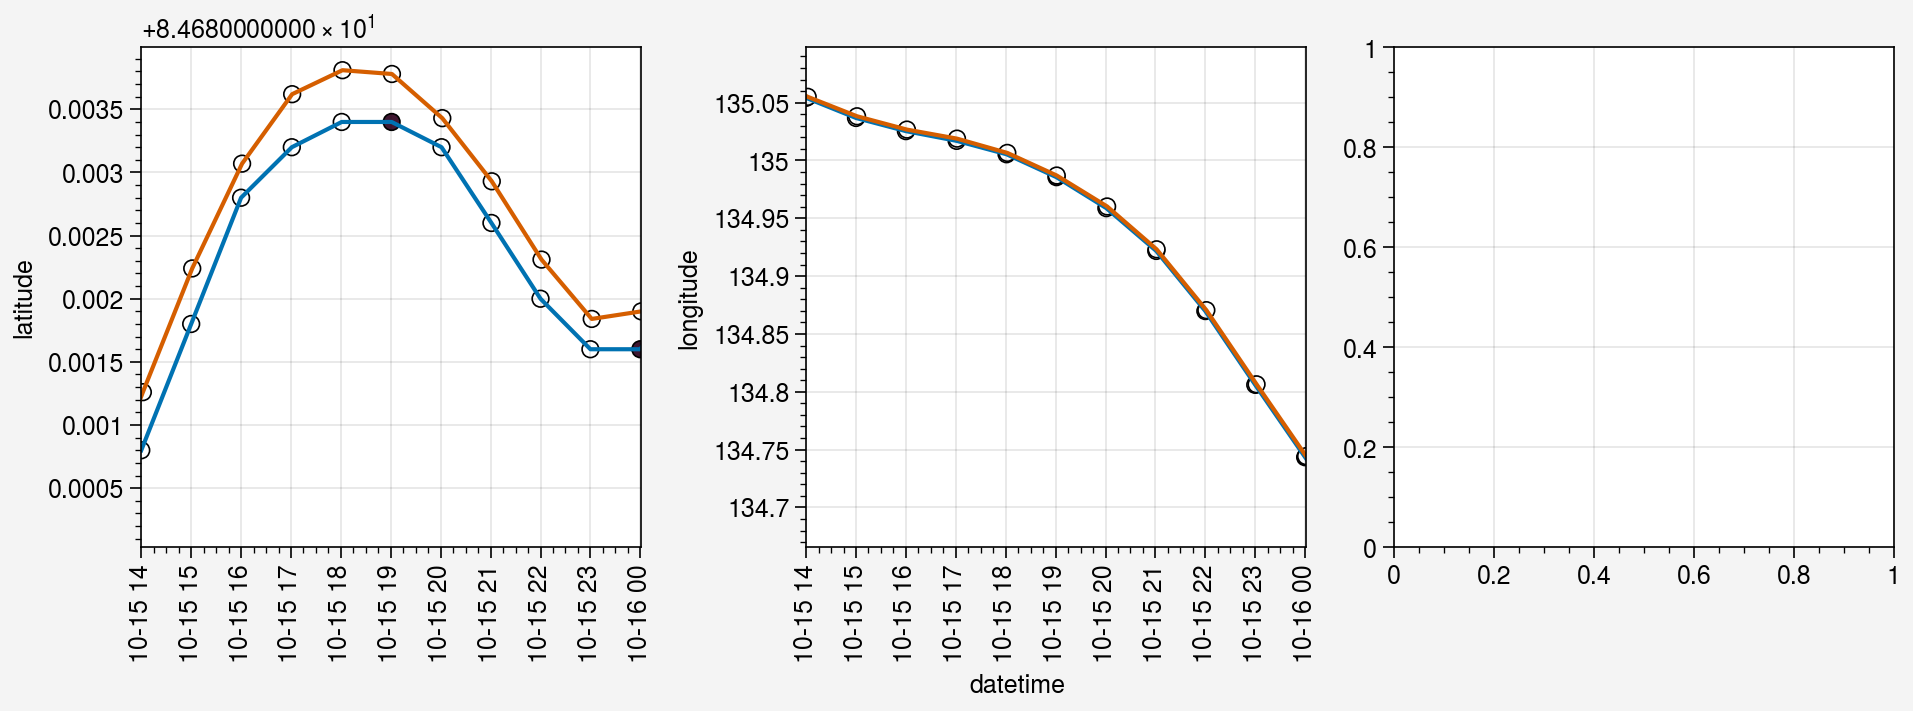

In [213]:
margin = pd.to_timedelta('6H')
date = pd.to_datetime('2019-10-15 19:01:00')
buoy_df = buoy_data['2019S93']
fig, ax = pplt.subplots(ncols=3, sharey=False)
for axis, var in zip(ax, ['latitude', 'longitude']):
    data = buoy_df.loc[slice(date - margin, date + margin)]
    axis.plot(data[var])
    axis.scatter(data.index, data[var], c=data['check_dups'].astype(int), edgecolor='k')

buoy_df = buoy_data['2019R9']
for axis, var in zip(ax, ['latitude', 'longitude']):
    data = buoy_df.loc[slice(date - margin, date + margin)]
    axis.plot(data[var])
    axis.scatter(data.index, data[var], c=data['check_dups'].astype(int), edgecolor='k')



    #    axis.plot(buoy_df2.loc[slice(date - margin, date + margin)][var], marker='.')
    
# ax[2].plot(speed[slice(date - margin, date + margin)], marker='.', label='2019R9')
# ax[2].plot(speed2[slice(date - margin, date + margin)], marker='.', label='2019S93')
# ax[2].legend(ncols=1)

In [312]:
clean = reload(clean)

In [308]:
metadata.groupby('Buoy Type').count()

,Deployment Leg,DN Station ID,IMEI,Deployment Date,Deployment Datetime,First Data Datetime,Last Data Datetime,Active,Sampling Frequency (hh:mm),Re-deployed As,Formerly Deployed As,Manufacturer,Model,PI,Data Authors,filename
Buoy Type,,,,,,,,,,,,,,,,
Atmospheric Surface Flux Station,13,13,13,13,13,13,13,13,13,9,9,13,13,13,13,13
CTD,9,9,9,9,9,9,9,9,9,1,1,9,9,9,9,9
DTOP Ocean Profiler,5,5,5,5,5,5,5,5,5,0,0,5,5,5,5,5
Flux Buoy,4,4,4,4,4,4,4,4,4,1,0,4,4,4,4,4
IMBFlex,5,5,5,5,5,5,5,5,5,0,0,5,5,5,5,5
LITO/Envipope,3,3,3,3,3,3,3,3,3,0,0,3,3,3,3,3
Radiation Station,6,6,6,6,6,6,6,6,6,1,1,6,6,6,6,6
SVP,114,114,114,114,114,114,114,114,114,3,4,114,114,114,114,114
Seasonal IMB,4,4,4,4,4,4,4,4,4,0,0,4,4,4,4,4


In [309]:
metadata.loc[metadata['Buoy Type'] == 'SVP'].groupby('Sampling Frequency (hh:mm)').count()

,Deployment Leg,DN Station ID,IMEI,Deployment Date,Deployment Datetime,First Data Datetime,Last Data Datetime,Active,Re-deployed As,Formerly Deployed As,Buoy Type,Manufacturer,Model,PI,Data Authors,filename
Sampling Frequency (hh:mm),,,,,,,,,,,,,,,,
00:10,13,13,13,13,13,13,13,13,0,0,13,13,13,13,13,13
00:30,47,47,47,47,47,47,47,47,0,0,47,47,47,47,47,47
01:00,48,48,48,48,48,48,48,48,3,4,48,48,48,48,48,48
03:00,6,6,6,6,6,6,6,6,0,0,6,6,6,6,6,6


In [323]:
t = pd.Series(buoy_data[buoy].index)
f = t.shift(-1) - t
print(f.median().round('1H').total_seconds())

3600.0


In [344]:
# From gumption's answer on Stackoverflow
# https://stackoverflow.com/questions/8906926/formatting-timedelta-objects/8907269#8907269

from string import Template

class DeltaTemplate(Template):
    delimiter = "%"

def strfdelta(tdelta, fmt):
    d = {"D": tdelta.days}
    hours, rem = divmod(tdelta.seconds, 3600)
    minutes, seconds = divmod(rem, 60)
    d["H"] = '{:02d}'.format(hours)
    d["M"] = '{:02d}'.format(minutes)
    d["S"] = '{:02d}'.format(seconds)
    t = DeltaTemplate(fmt)
    return t.substitute(**d)
metadata['SamplingFrequencyCalculated'] = np.nan
for buoy in buoy_data:
    t = pd.Series(buoy_data[buoy].index)
    f = t.shift(-1) - t
    metadata.loc[buoy, 'SamplingFrequencyCalculated'] = strfdelta(f.median().round('10min'), '%H:%M')

In [345]:
metadata.loc[[x[0] == 'P' for x in metadata['DN Station ID']]].groupby('SamplingFrequencyCalculated').count()

,Deployment Leg,DN Station ID,IMEI,Deployment Date,Deployment Datetime,First Data Datetime,Last Data Datetime,Active,Sampling Frequency (hh:mm),Re-deployed As,Formerly Deployed As,Buoy Type,Manufacturer,Model,PI,Data Authors,filename,SamplingFrequencyCalculatde
SamplingFrequencyCalculated,,,,,,,,,,,,,,,,,,
00:10,9,9,9,9,9,9,9,9,9,0,0,9,9,9,9,9,9,9
00:30,36,36,36,36,36,36,36,36,36,0,0,36,36,36,36,36,36,36
01:00,53,53,53,53,53,53,53,53,53,0,1,53,53,53,53,53,53,53
02:00,10,10,10,10,10,10,10,10,10,0,0,10,10,10,10,10,10,10
03:00,6,6,6,6,6,6,6,6,6,0,0,6,6,6,6,6,6,6
12:00,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1


In [346]:
metadata.loc[[x[0] == 'P' for x in metadata['DN Station ID']]].groupby('Sampling Frequency (hh:mm)').count()

,Deployment Leg,DN Station ID,IMEI,Deployment Date,Deployment Datetime,First Data Datetime,Last Data Datetime,Active,Re-deployed As,Formerly Deployed As,Buoy Type,Manufacturer,Model,PI,Data Authors,filename,SamplingFrequencyCalculated,SamplingFrequencyCalculatde
Sampling Frequency (hh:mm),,,,,,,,,,,,,,,,,,
00:10,13,13,13,13,13,13,13,13,0,0,13,13,13,13,13,13,13,13
00:30,51,51,51,51,51,51,51,51,0,0,51,51,51,51,51,51,51,51
01:00,43,43,43,43,43,43,43,43,0,1,43,43,43,43,43,43,43,43
02:00,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1
03:00,6,6,6,6,6,6,6,6,0,0,6,6,6,6,6,6,6,6
12:00,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1


In [349]:
metadata.loc[[x['Sampling Frequency (hh:mm)'] != x['SamplingFrequencyCalculated']
    for name, x in metadata.iterrows()], ['Sampling Frequency (hh:mm)', 'SamplingFrequencyCalculated', 'PI']]

,Sampling Frequency (hh:mm),SamplingFrequencyCalculated,PI
Sensor ID,,,
2019F4,03:00,02:00,Stanton
2019S96,00:10,01:00,Nicolaus
2019T69,02:00,01:00,Lei
2019P142,01:00,02:00,Lei
2019P138,01:00,02:00,Lei
2019P145,01:00,02:00,Lei
2019P140,01:00,02:00,Lei
2019P137,01:00,02:00,Lei
2019P143,01:00,02:00,Lei


In [518]:
# Buoy error correction by frequency, PI
set_two = metadata.loc[metadata.Manufacturer == 'TUT', ['DN Station ID', 'PI', 'SamplingFrequencyCalculated']].index
metadata.loc[metadata.Manufacturer == 'TUT', ['DN Station ID', 'PI', 'SamplingFrequencyCalculated']]

,DN Station ID,PI,SamplingFrequencyCalculated
Sensor ID,,,
2019P142,P008,Lei,02:00
2019P138,P013,Lei,02:00
2019P145,P020,Lei,02:00
2019P140,P021,Lei,02:00
2019P136,P025,Lei,01:00
2019P137,P026,Lei,02:00
2019P143,P032,Lei,02:00
2019P135,P033,Lei,02:00
2019P146,P034,Lei,02:00


In [354]:
# Apply QC to Hutchings buoys
set_one = metadata.loc[metadata.PI == 'Hutchings', ['DN Station ID', 'Manufacturer', 'SamplingFrequencyCalculated']].index
for buoy in set_one:
    buoy_df = buoy_data[buoy].copy()
    buoy_df['flag_date'] = clean.check_dates(buoy_df, date_index=True)
    buoy_df['flag_duplicate'] = clean.check_dates(buoy_df, date_index=True)
    buoy_df['flag_position_pass_one'] = clean.check_position_splines(buoy_df, 'longitude', 'latitude',
                                                                    df=31, fit_window='48H', sigma=6)
    buoy_df['flag_position_pass_two'] = clean.check_position_splines(buoy_df.loc[buoy_df.flag_position_pass_one == 0].copy(), 'longitude', 'latitude',
                                                                    df=31, fit_window='48H', sigma=6)
    buoy_data[buoy] = buoy_df.copy()
    print(buoy, buoy_df['flag_position_pass_one'].sum(), buoy_df['flag_position_pass_two'].sum())

# Additional manual QC
# Flag dates where it's washed up on shore
buoy_data['2019P205'].loc[buoy_data[buoy].index >= '2020-10-22 22:30:00', 'flag'] = 1

# Flag summer dates where reporting becomes sporadic
buoy_data['2019P197'].loc[slice('2020-07-01', '2020-09-15'), 'flag'] = 1
buoy_data['2019P196'].loc[slice('2020-05-15', '2020-09-15'), 'flag'] = 1

# Caught by the spline tool: 2019P196, 2019P203, 2019P183, 2020P219*, 2020P220*, 
# Caught by date / isolated points: 2019P199, 2019P203, 2020P195, 2020P186
# * two passes necessary
# 2020P219 was placed at 10 min reporting a few times during the spring of 2020

for buoy in set_one:
    buoy_df = buoy_data[buoy].copy()
    buoy_df['flag'] = buoy_df.loc[:,['flag', 'flag_duplicate', 'flag_date',
                                   'flag_position_pass_one', 'flag_position_pass_two']].sum(axis=1) > 0
    buoy_df['flag'] = buoy_df['flag'].astype(int)
    buoy_df.to_csv('../data/mosaic_qc/' + metadata.loc[buoy, 'filename'] + '.csv')

2019P207 0 0
2019P204 0 0
Flagged date  2020-10-29 22:00:28
Flagged date  2020-10-31 09:30:27
Flagged date  2020-11-09 14:30:31
Flagged date  2020-10-29 09:30:27
Flagged date  2020-11-09 07:30:29
2019P205 3 2.0
2019P197 0 0
2019P201 0 0
2019P208 0 0
2019P202 0 0
2019P209 0 0
2019P199 0 0
2019P193 0 0
2019P195 0 0
2019P188 0 0
Flagged date  2019-10-26 10:31:57
2019P206 1 0.0
2019P196 0 0
2019P198 0 0
Flagged date  2020-01-29 02:34:00
Flagged date  2020-04-12 17:00:39
2019P203 2 0.0
2019P200 0 0
2019P189 0 0
2019P192 0 0
2019P191 0 0
2019P194 0 0
2019P187 0 0
2019P182 0 0
2019P184 0 0
Flagged date  2020-01-20 05:33:59
2019P183 1 0.0
2020P216 0 0
Flagged date  2020-05-08 03:40:24
Flagged date  2020-05-08 03:45:25
Flagged date  2020-05-08 03:50:26
Flagged date  2020-08-27 19:00:25
Flagged date  2020-05-08 03:35:27
2020P219 4 1.0
2020P185 0 0
2020P217 0 0
Flagged date  2020-08-19 23:34:02
Flagged date  2020-08-20 04:34:05
2020P218 2 0.0
Flagged date  2020-05-08 03:40:24
Flagged date  2020-0

In [519]:
%%time
# Apply QC to TUT buoys
set_two = metadata.loc[metadata.Manufacturer == 'TUT', :].index
for buoy in set_two:
    buoy_df = buoy_data[buoy].copy()
    buoy_df['flag_date'] = clean.check_dates(buoy_df, date_index=True)
    buoy_df['flag_duplicate'] = clean.check_dates(buoy_df, date_index=True)
    buoy_df['flag_position_pass_one'] = clean.check_position_splines(buoy_df, 'longitude', 'latitude',
                                                                    df=31, fit_window='48H', sigma=6)
    buoy_df['flag_position_pass_two'] = clean.check_position_splines(buoy_df.loc[buoy_df.flag_position_pass_one == 0].copy(), 'longitude', 'latitude',
                                                                    df=31, fit_window='48H', sigma=6)
    buoy_data[buoy] = buoy_df.copy()
    print(buoy, buoy_df['flag_position_pass_one'].sum(), buoy_df['flag_position_pass_two'].sum())



Flagged date  2020-05-25 01:00:00
2019P142 1 0.0
2019P138 0 0
2019P145 0 0
2019P140 0 0
Flagged date  2020-09-16 00:30:01
2019P136 1 0.0
Flagged date  2020-05-01 20:30:00
Flagged date  2020-05-21 01:30:00
2019P137 2 0.0
2019P143 0 0
2019P135 0 0
2019P146 0 0
2019P148 0 0
Flagged date  2020-06-30 15:30:04
2019P139 1 0.0
Flagged date  2020-09-20 10:30:00
Flagged date  2020-12-31 17:29:59
2019P144 2 0.0
CPU times: user 6min 35s, sys: 1.97 s, total: 6min 37s
Wall time: 6min 37s


In [520]:
for buoy in set_two:
    buoy_df = buoy_data[buoy].copy()
    any_flags = buoy_df.flag_date | buoy_df.flag_duplicate | buoy_df.flag_position_pass_one | buoy_df.flag_position_pass_two
    if any_flags.sum() > 0:
        print(buoy, sum(any_flags))

2019P142 1
2019P136 1
2019P137 2
2019P139 1
2019P144 2


In [528]:
test_df = pd.DataFrame(
    [['2019R9', '2020-04-23 11:01:09', 'check_speed', True],
     ['2019R9', '2020-05-17 01:02:20', 'check_speed', True],
     ['2020P171','2020-12-13 00:04:00', 'check_speed', True],
     ['2020P171', '2021-01-08 20:04:01', 'check_speed', True],
     ['2020P171', '2021-01-08 16:04:02', 'check_speed', True],
     ['2019P178', '2021-01-21 13:00:28', 'check_speed', True],
     ['2019P142', '2020-04-04 14:30:00', 'check_speed', True],
     ['2019P142', '2020-05-25 01:00:00', 'check_speed', True], 
      ['2019P142', '2020-07-23 00:59:59', 'check_speed', True]],
    columns=['buoy_id', 'date', 'check_var', 'true_val'])
test_df['date'] = pd.to_datetime(test_df.date.values)

In [526]:
test_df.loc[test_df.buoy_id == '2019P142']


,buoy_id,date,check_var,true_val
6,2019P142,2020-04-04 14:30:00,check_speed,True
7,2019P142,2020-05-25 01:00:00,check_speed,True
8,2019P142,2020-07-23 00:59:59,check_speed,True


In [ ]:
date = '2020-05-25 01:00:00	'
buoy_df.loc[]

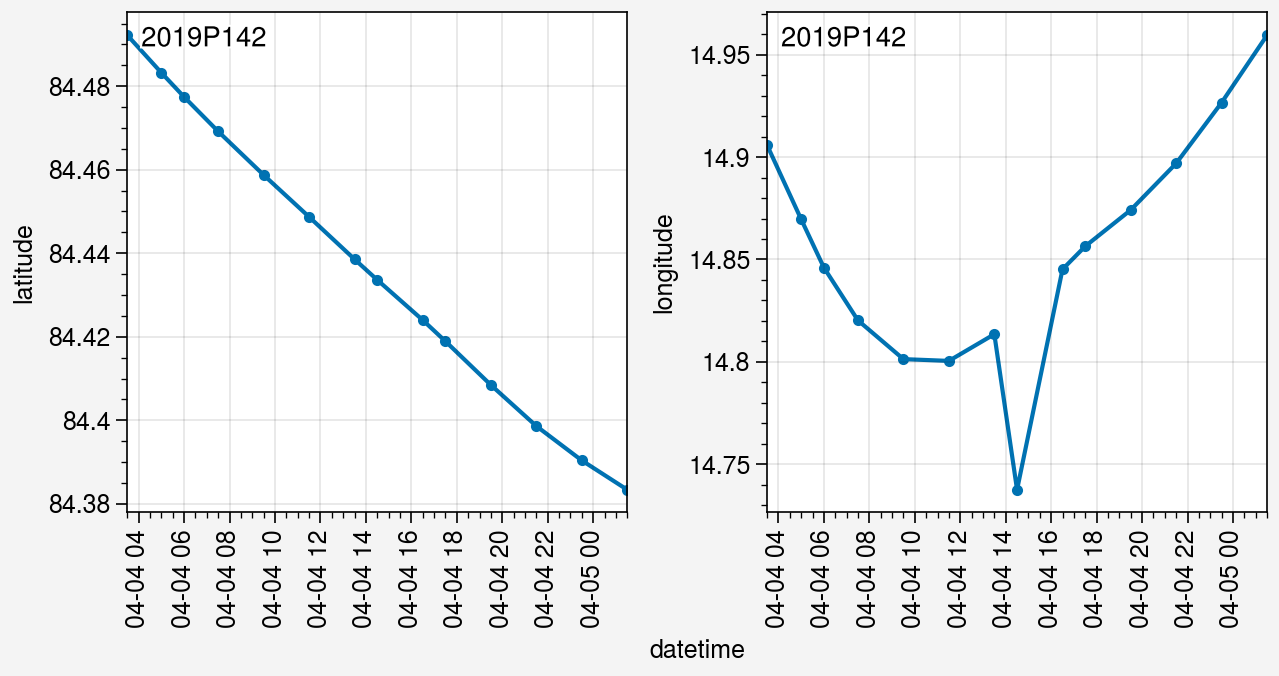

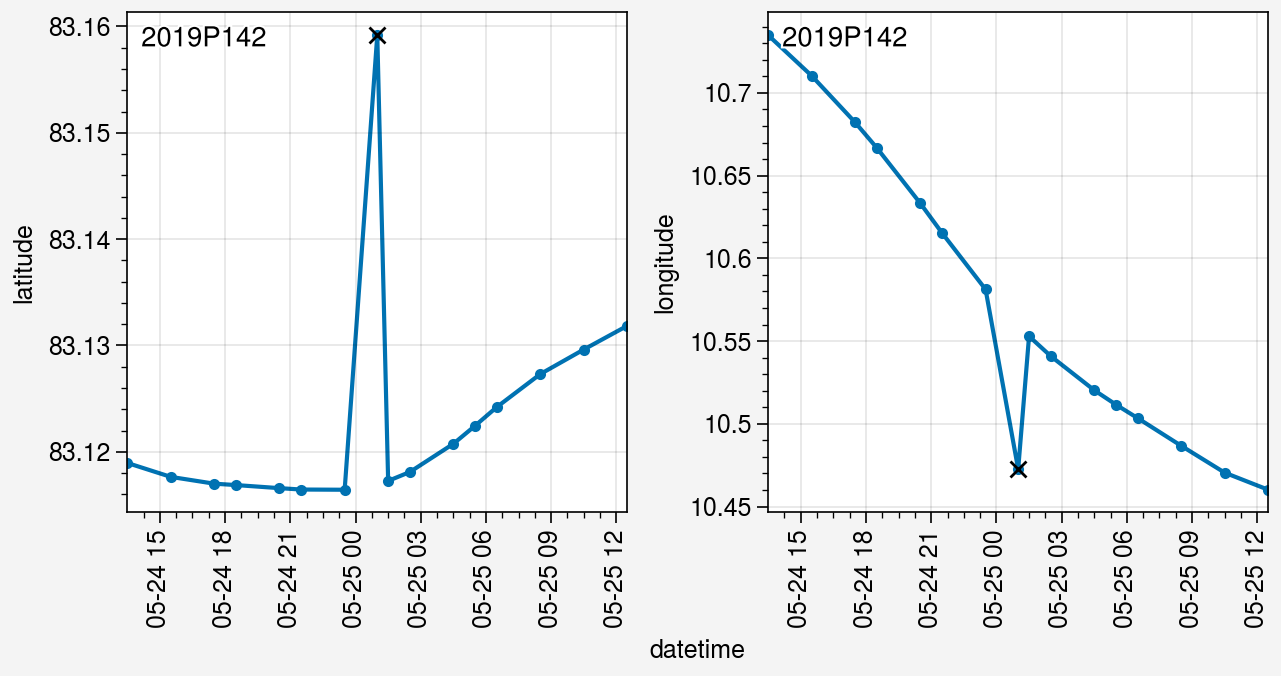

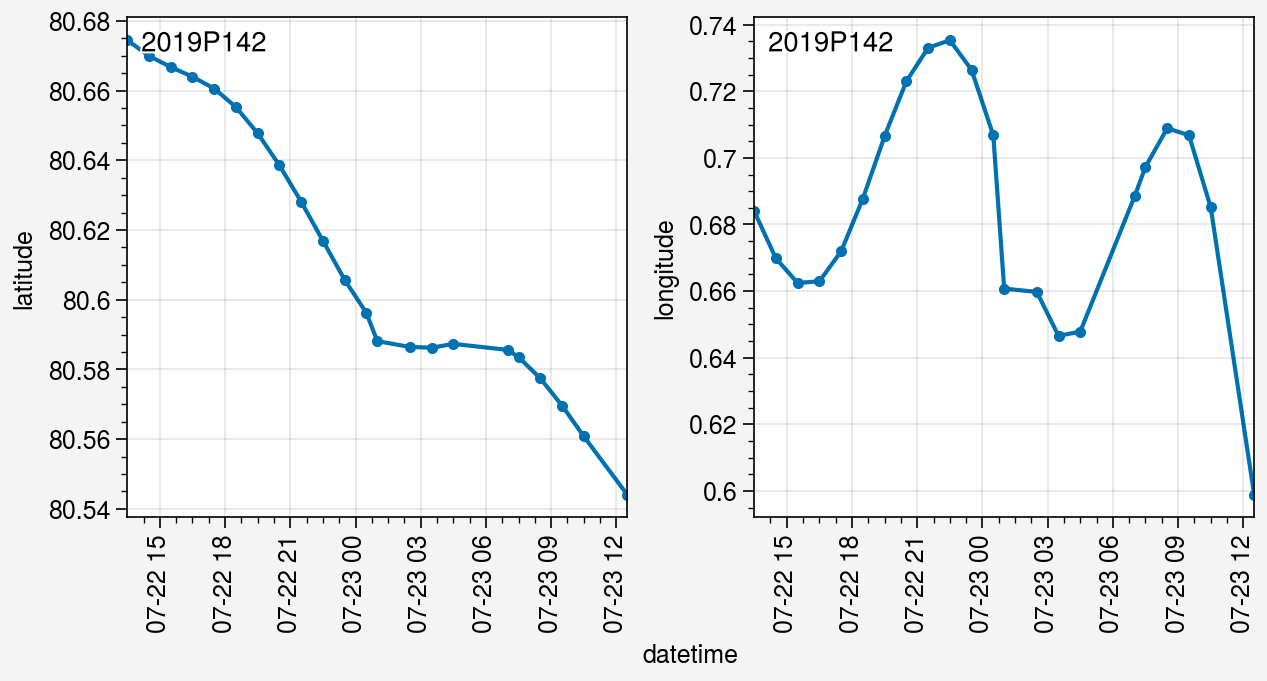

In [529]:
# Checking whether the flagged values are outliers or not
# by marking the flagged values and showing the 48 hour period centered on each
margin = pd.to_timedelta('12H')

for buoy in ['2019P142']:
    buoy_df = buoy_data[buoy].copy()
    any_flags = buoy_df.flag_date | buoy_df.flag_duplicate | buoy_df.flag_position_pass_one | buoy_df.flag_position_pass_two
    if sum(any_flags) < 20:
        for date in test_df.loc[test_df.buoy_id == buoy].date:
#        for date in buoy_df.loc[any_flags].index:
            fig, ax = pplt.subplots(ncols=2, sharey=False)
            for axis, var in zip(ax, ['latitude', 'longitude']):
                data = buoy_df.loc[slice(date - margin, date + margin)]
                axis.plot(data[var], marker='.', zorder=0)
                axis.plot(data[var].where(data['flag_date']), marker='o', color='r', lw=0, zorder=1)
                axis.plot(data[var].where(data['flag_duplicate']), marker='.', color='y', lw=0, zorder=2)
                axis.plot(data[var].where(data['flag_position_pass_one'] > 0), marker='x', color='k', lw=0, zorder=3)
                axis.plot(data[var].where(data['flag_position_pass_two'] > 0), marker='o', edgecolor='k', facecolor='none',
                          markersize=5, lw=0, zorder=4)
            ax.format(ultitle=buoy)
        

<AxesSubplot:xlabel='datetime'>

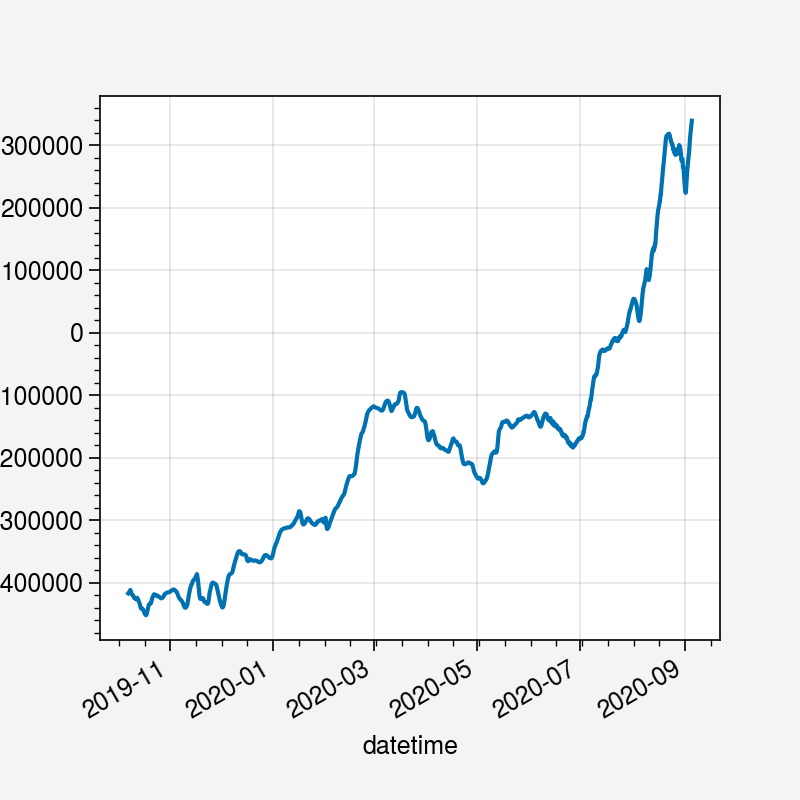

## Notes on where buoy time series end
2019P205 - flag duplicates default fails although it's washed up on Iceland coast. The position uncertainty could be estimated for data after landfall (`2020-10-22 22:30:55`)

In [461]:
# Flag dates where it's washed up on shore
buoy_data['2019P205'].loc[buoy_data[buoy].index >= '2020-10-22 22:30:00', 'flag'] = 1

# Flag summer dates where reporting becomes sporadic
buoy_data['2019P197'].loc[slice('2020-07-01', '2020-09-15'), 'flag'] = 1
buoy_data['2019P196'].loc[slice('2020-05-15', '2020-09-15'), 'flag'] = 1

# Caught by the spline tool: 2019P196, 2019P203, 2019P183, 2020P219*, 2020P220*, 
# Caught by date / isolated points: 2019P199, 2019P203, 2020P195, 2020P186
# * two passes necessary
# 2020P219 was placed at 10 min reporting a few times during the spring of 2020


In [516]:
for buoy in set_one:
    buoy_df = buoy_data[buoy].copy()
    buoy_df['flag'] = buoy_df.loc[:,['flag', 'flag_duplicate', 'flag_date',
                                   'flag_position_pass_one', 'flag_position_pass_two']].sum(axis=1) > 0
    buoy_df['flag'] = buoy_df['flag'].astype(int)
    buoy_df.to_csv('../data/mosaic_qc/' + metadata.loc[buoy, 'filename'] + '.csv')

,flag_duplicate
datetime,
2019-10-10 03:00:26,False
2019-10-10 03:30:26,False
2019-10-10 04:00:25,False
2019-10-10 04:30:55,False
2019-10-10 05:00:25,False
...,...
2020-05-09 07:00:27,False
2020-05-09 07:30:32,False
2020-05-09 08:00:26,False


In [495]:
check_dates = clean.check_dates(buoy_df, date_index=True, check_gaps=True, gap_threshold=6)

In [505]:
buoy_df.loc[slice('2021-02-10', '2021-06-01')].sum()

latitude                  1.480705e+04
longitude                -7.036591e+03
check_dates               2.030000e+02
check_dups                0.000000e+00
check_speed               0.000000e+00
x                         3.984303e+08
y                         7.340771e+08
flag_date                 2.030000e+02
flag_duplicate            2.030000e+02
flag                      0.000000e+00
flag_position_pass_one    0.000000e+00
flag_position_pass_two    0.000000e+00
dtype: float64

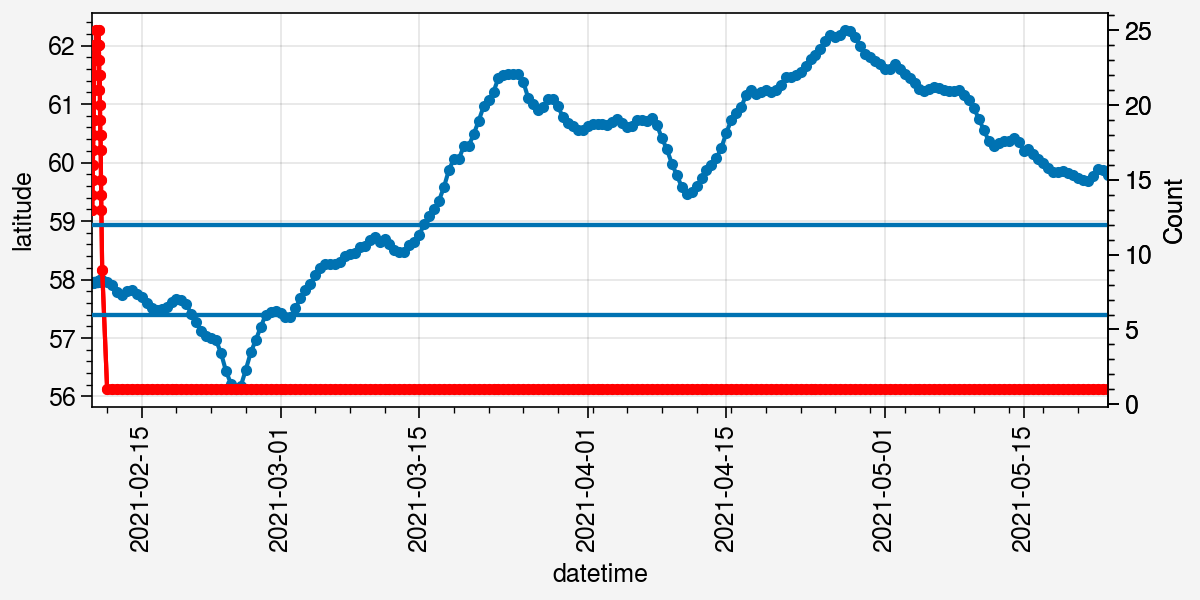

In [503]:
fig, ax = pplt.subplots(width=6, height=3)
timeslice = slice('2021-02-10', '2021-09-25')
ax.plot(buoy_df.loc[timeslice].latitude, marker='.')
#ax.plot(buoy_df.loc[check_dates].loc[timeslice].latitude, marker='.')
ax2 = ax.twinx()
ax2.plot(buoy_df.loc[timeslice].rolling(window='12H', center=True).latitude.count(), marker='.', color='r')
ax2.format(ylabel='Count')
ax2.axhline(6)
ax2.axhline(12)

In [ ]:
buoy_df

In [ ]:
def flag_isolated_points(buoy_df, date_index=False, window='12H', min_number=4):
    """Flag points that have less than min_number in a centered 12H window."""
    return buoy_df.rolling(window, center=True, min_periods=0).latitude.count() < min_number


<AxesSubplot:xlabel='datetime'>

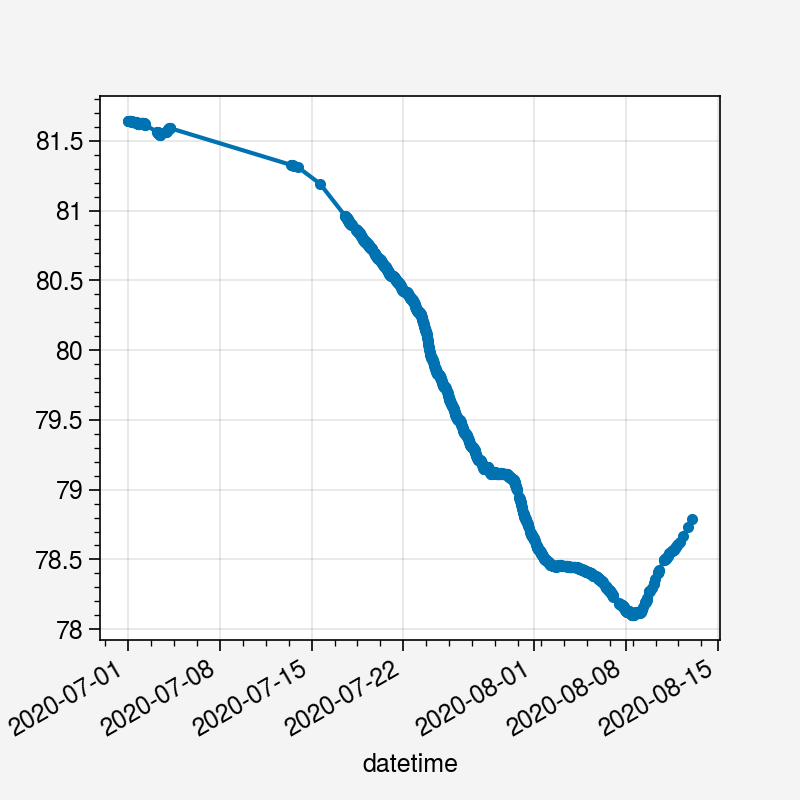

In [438]:
# test = clean.flag_duplicates(buoy_df.round(5), date_index=True)
# test2 = (buoy_df.latitude == buoy_df.rolling(7, center=True).latitude.max()) | \
#         (buoy_df.latitude == buoy_df.rolling(7, center=True).latitude.min()) | \
#         (buoy_df.longitude == buoy_df.rolling(7, center=True).longitude.max()) | \
#         (buoy_df.longitude == buoy_df.rolling(7, center=True).longitude.min()) 

# testdf = pd.DataFrame({'dup': test, 'max_min': test2})
# testdf.loc[test & ~test2].head(20)
buoy_df.loc[buoy_df.index > pd.to_datetime('2020-07-01')].latitude.plot(marker='.')

<a list of 1 Line2D objects>

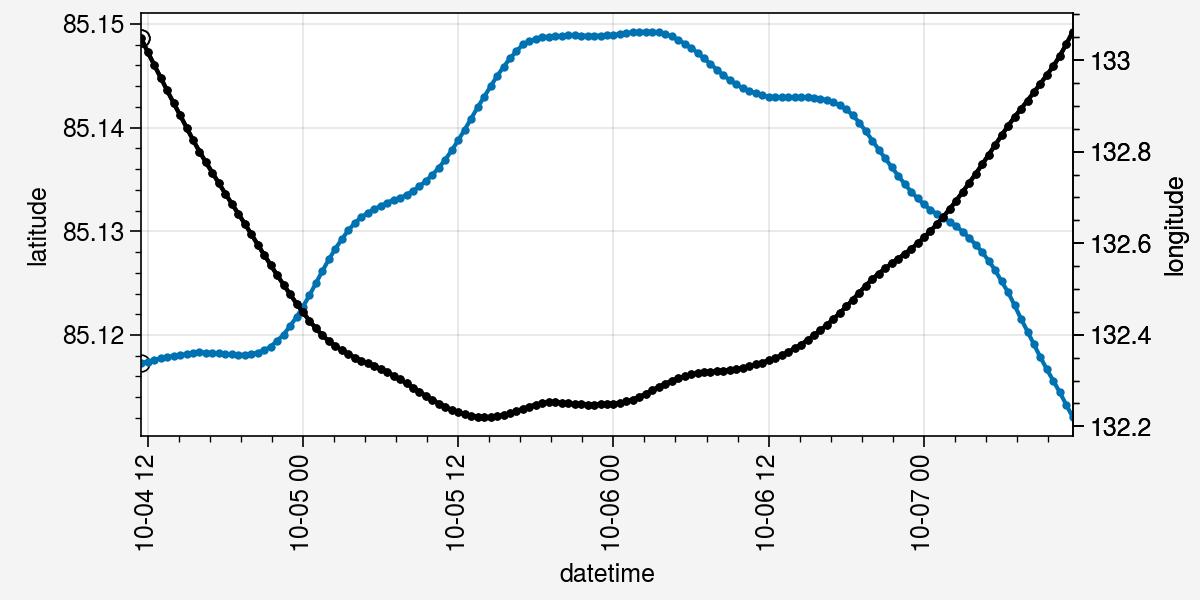

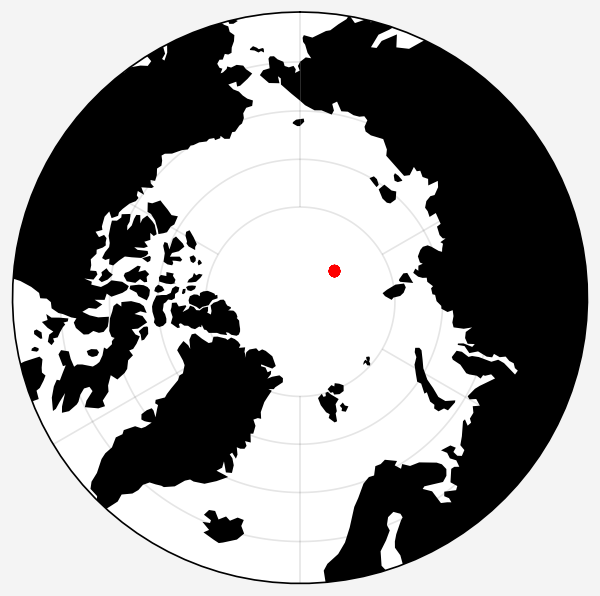

In [433]:
buoy = '2019P197'
buoy_df = buoy_data[buoy].copy()
any_flags = buoy_df.flag_date | buoy_df.flag_duplicate | buoy_df.flag_position_pass_one | buoy_df.flag_position_pass_two
date = pd.to_datetime(buoy_df.index[0])
margin=pd.to_timedelta('72H')
ts = slice(date - margin, date + margin)
# Show time series
fig, ax = pplt.subplots(width=6, height=3)
ax.plot(buoy_df.loc[ts].latitude, marker='.', markersize=4)
ax.scatter(date, buoy_df.loc[date, 'latitude'], facecolor='none', edgecolor='k')
ax2 = ax.twinx()
ax2.plot(buoy_df.loc[ts].longitude, marker='.', color='k', markersize=4)
ax2.scatter(date, buoy_df.loc[date, 'longitude'], facecolor='none', edgecolor='k')
# Show on map
fig, ax = pplt.subplots(width=3, proj='npstere')
ax.format(boundinglat=60, land=True)
ax.plot(buoy_df.loc[ts].longitude, buoy_df.loc[ts].latitude, marker='.', color='r', zorder=2)
#ax.plot(buoy_df.latitude, lw=0, marker='.')
#print(buoy_df.loc[ts].head())

In [426]:
for buoy in set_one:
    buoy_df = buoy_data[buoy].copy()
    any_flags = buoy_df.flag_date | buoy_df.flag_duplicate | buoy_df.flag_position_pass_one | buoy_df.flag_position_pass_two
    if sum(any_flags) < 20:
        if sum(any_flags) > 0:
            print(buoy)

2019P205
2019P197
2019P199
2019P206
2019P196
2019P203
2019P183
2020P219
2020P185
2020P218
2020P220


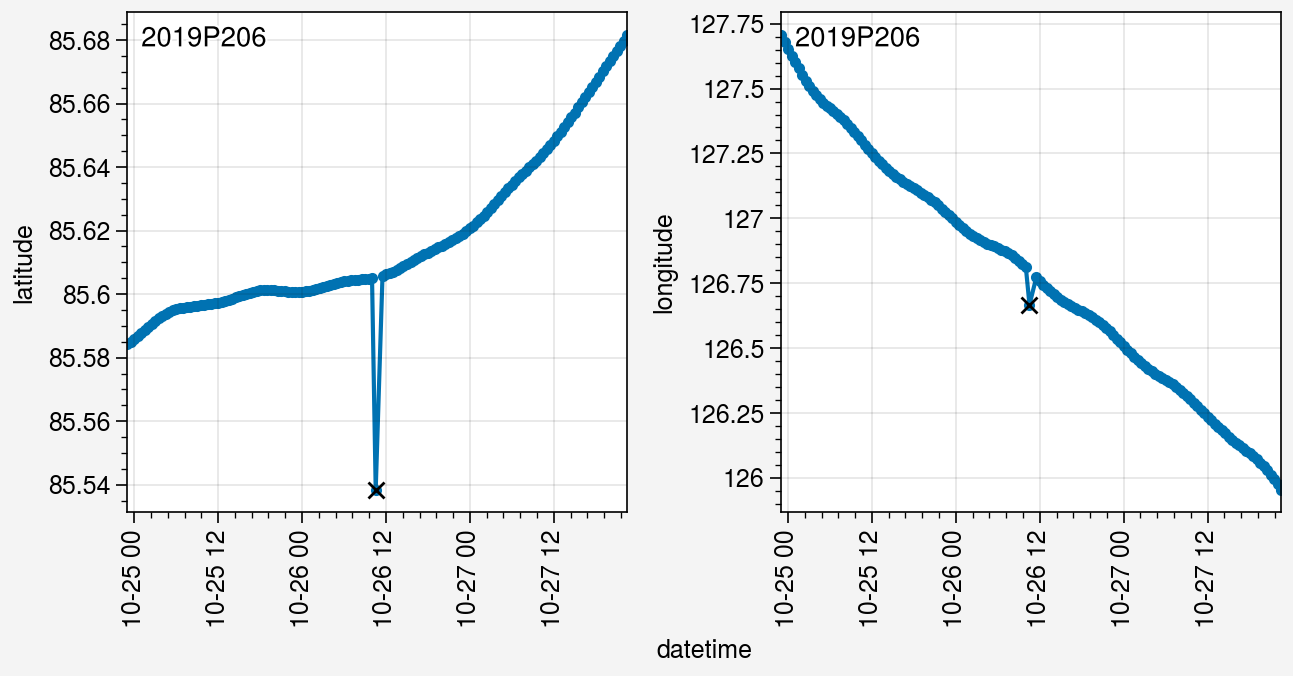

In [464]:
# Checking whether the flagged values are outliers or not
# by marking the flagged values and showing the 48 hour period centered on each
margin = pd.to_timedelta('36H')

for buoy in ['2019P196']:
    buoy_df = buoy_data[buoy].copy()
    any_flags = buoy_df.flag_date | buoy_df.flag_duplicate | buoy_df.flag_position_pass_one | buoy_df.flag_position_pass_two
    if sum(any_flags) < 20:
        for date in buoy_df.loc[any_flags].index:
            fig, ax = pplt.subplots(ncols=2, sharey=False)
            for axis, var in zip(ax, ['latitude', 'longitude']):
                data = buoy_df.loc[slice(date - margin, date + margin)]
                axis.plot(data[var], marker='.', zorder=0)
                axis.plot(data[var].where(data['flag_date']), marker='o', color='r', lw=0, zorder=1)
                axis.plot(data[var].where(data['flag_duplicate']), marker='.', color='y', lw=0, zorder=2)
                axis.plot(data[var].where(data['flag_position_pass_one'] > 0), marker='x', color='k', lw=0, zorder=3)
                axis.plot(data[var].where(data['flag_position_pass_two'] > 0), marker='o', edgecolor='k', facecolor='none',
                          markersize=5, lw=0, zorder=4)
            ax.format(ultitle=buoy)
        

In [279]:
test = clean.check_position_splines(buoy_df,
          'longitude', 'latitude', df=31,
          fit_window='48H', sigma=6)

Flagged date  2020-12-13 00:04:00
Flagged date  2021-02-11 15:04:00
Flagged date  2021-02-18 08:04:01
Flagged date  2021-02-26 04:04:04
Flagged date  2021-03-05 12:04:03
Flagged date  2021-03-30 08:04:01
Flagged date  2021-04-16 00:04:03
Flagged date  2021-04-24 19:04:04


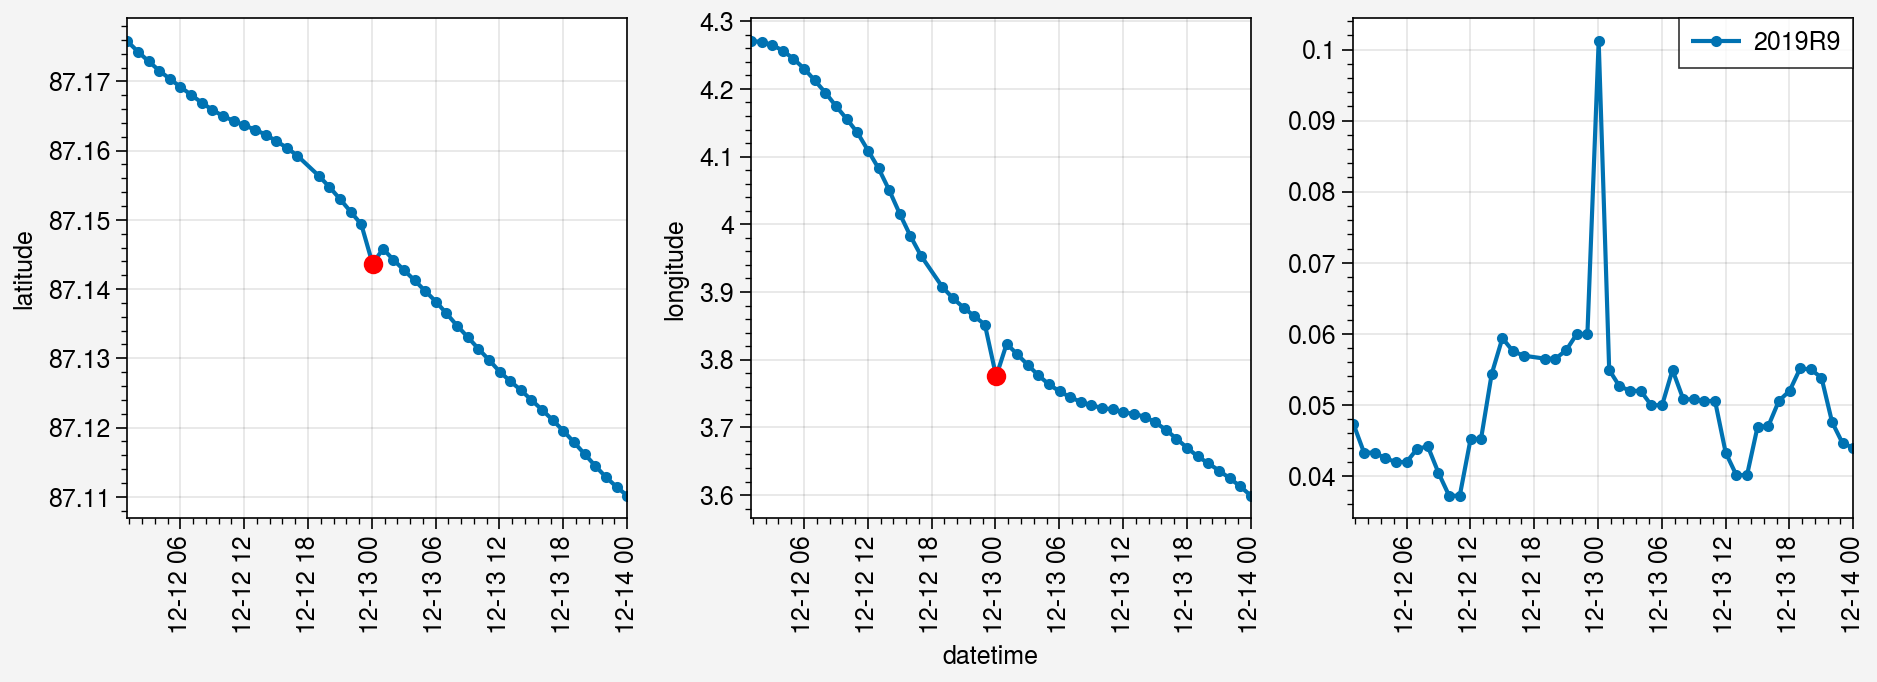

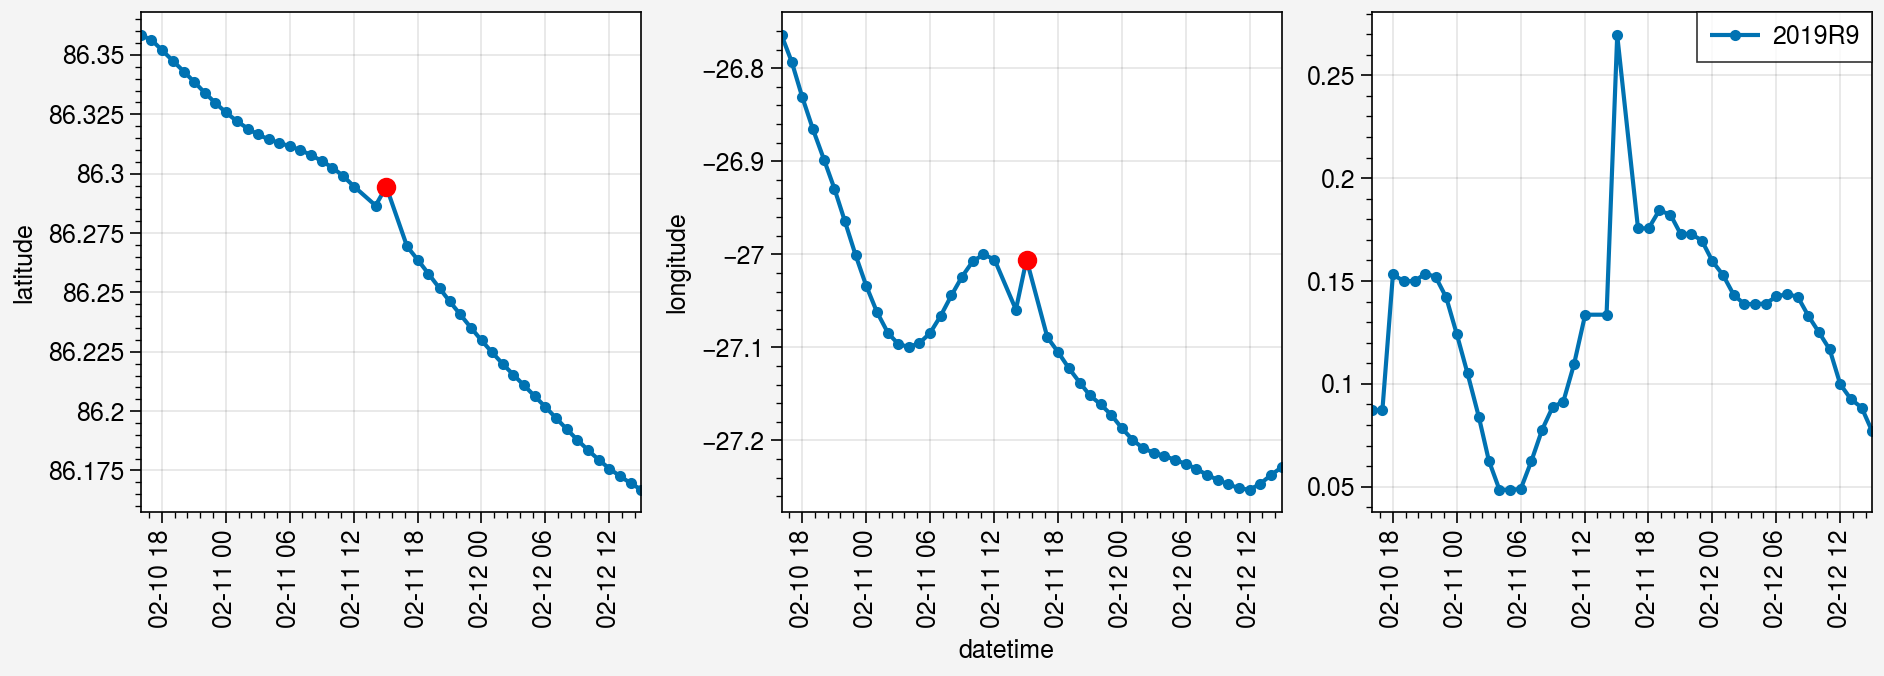

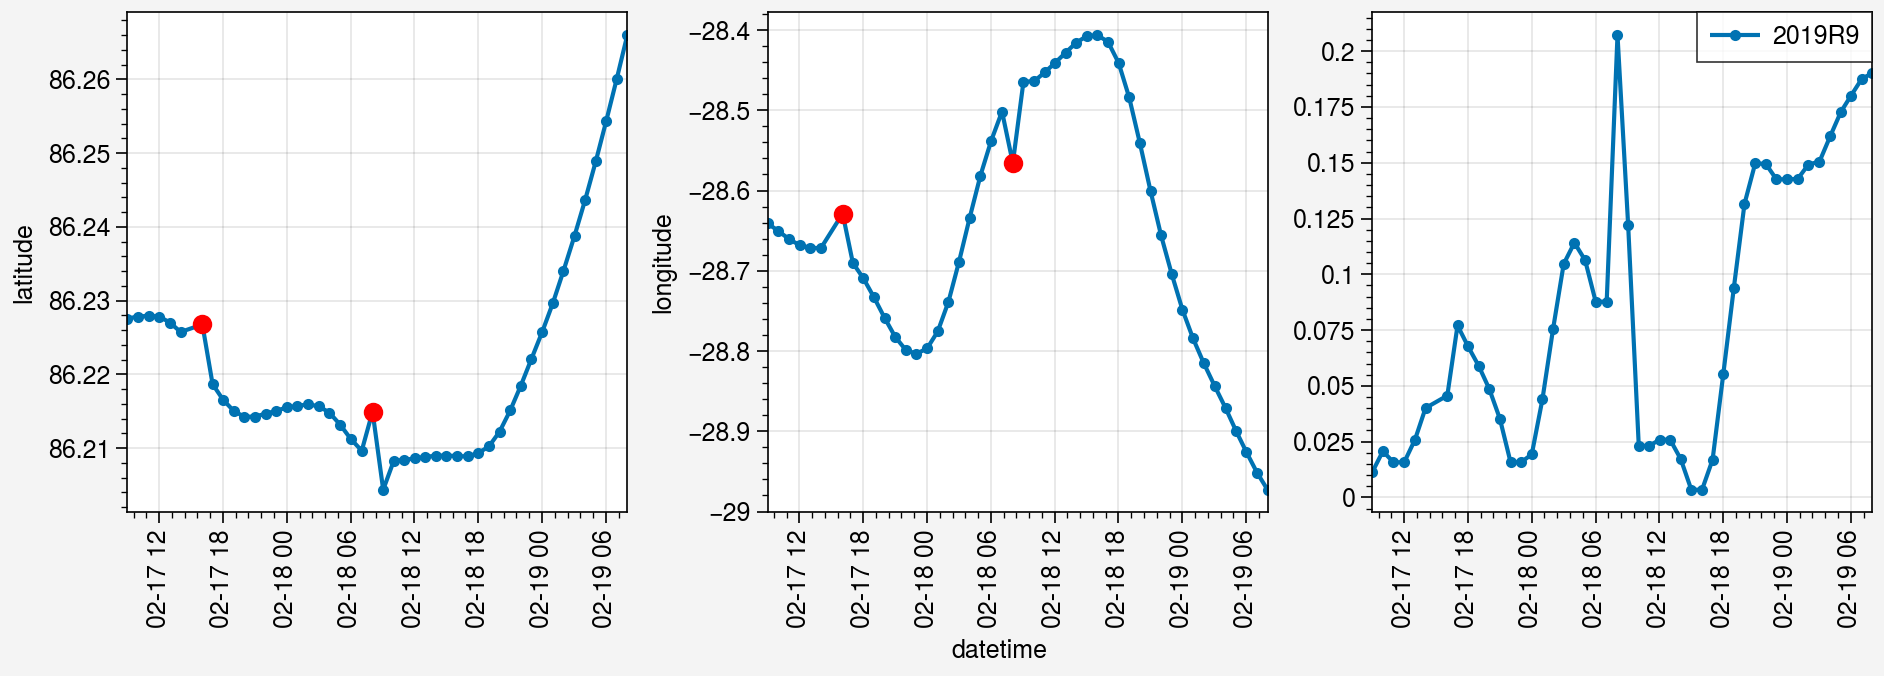

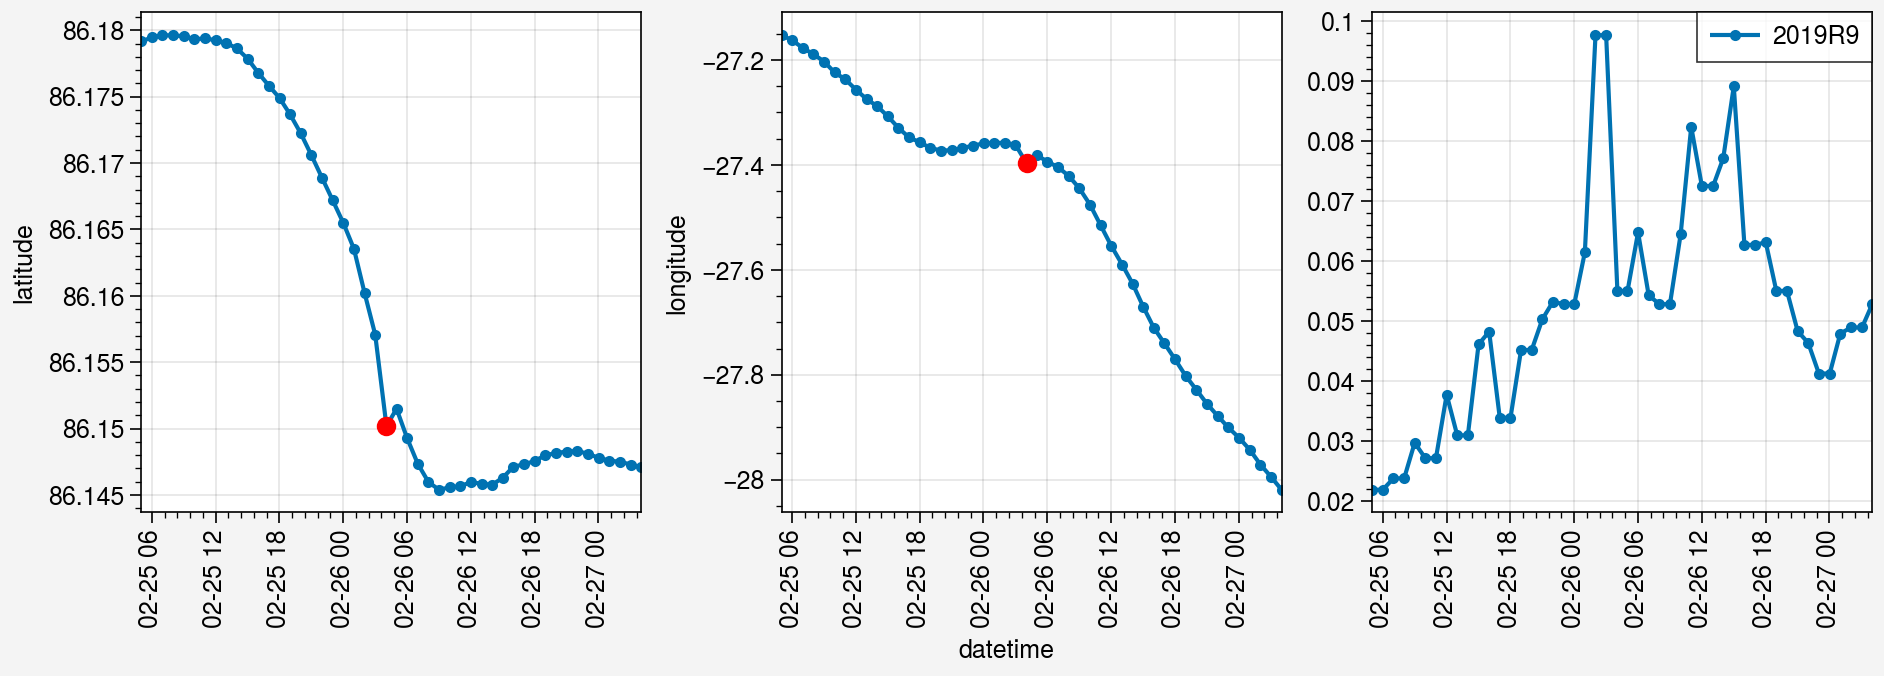

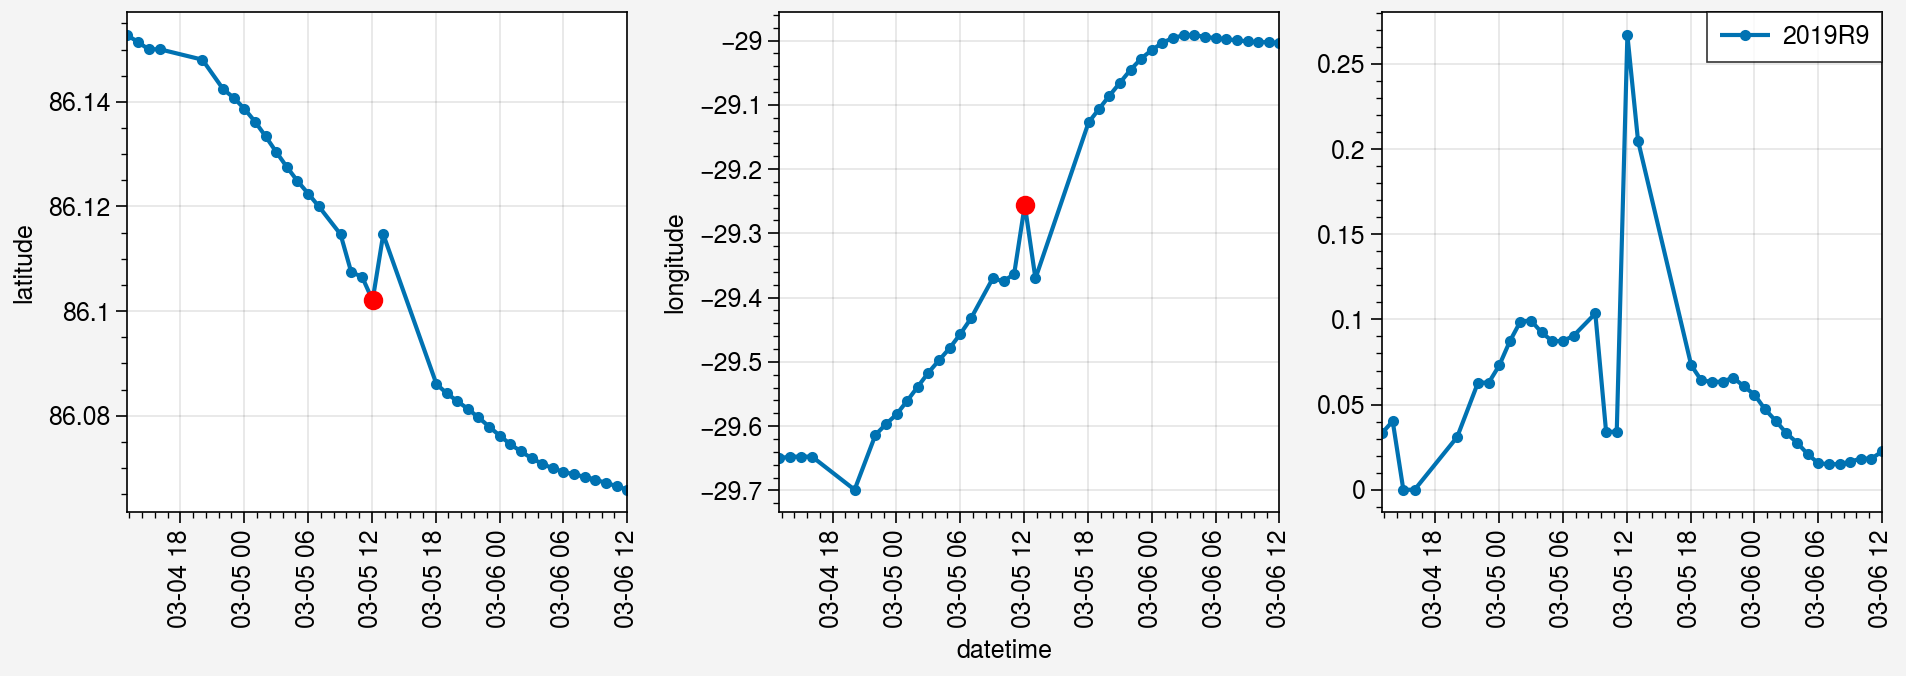

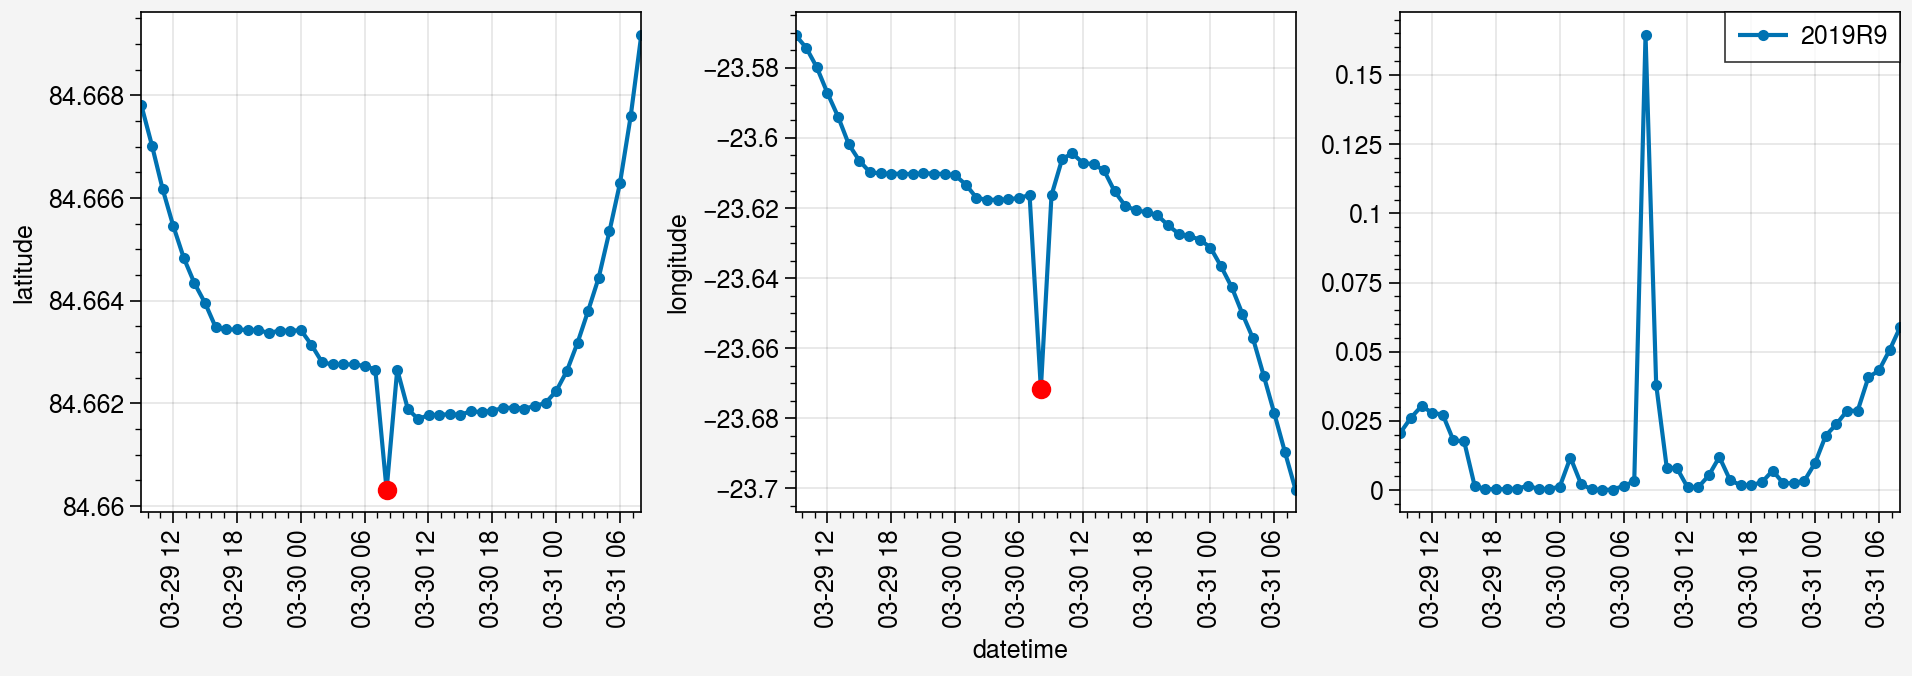

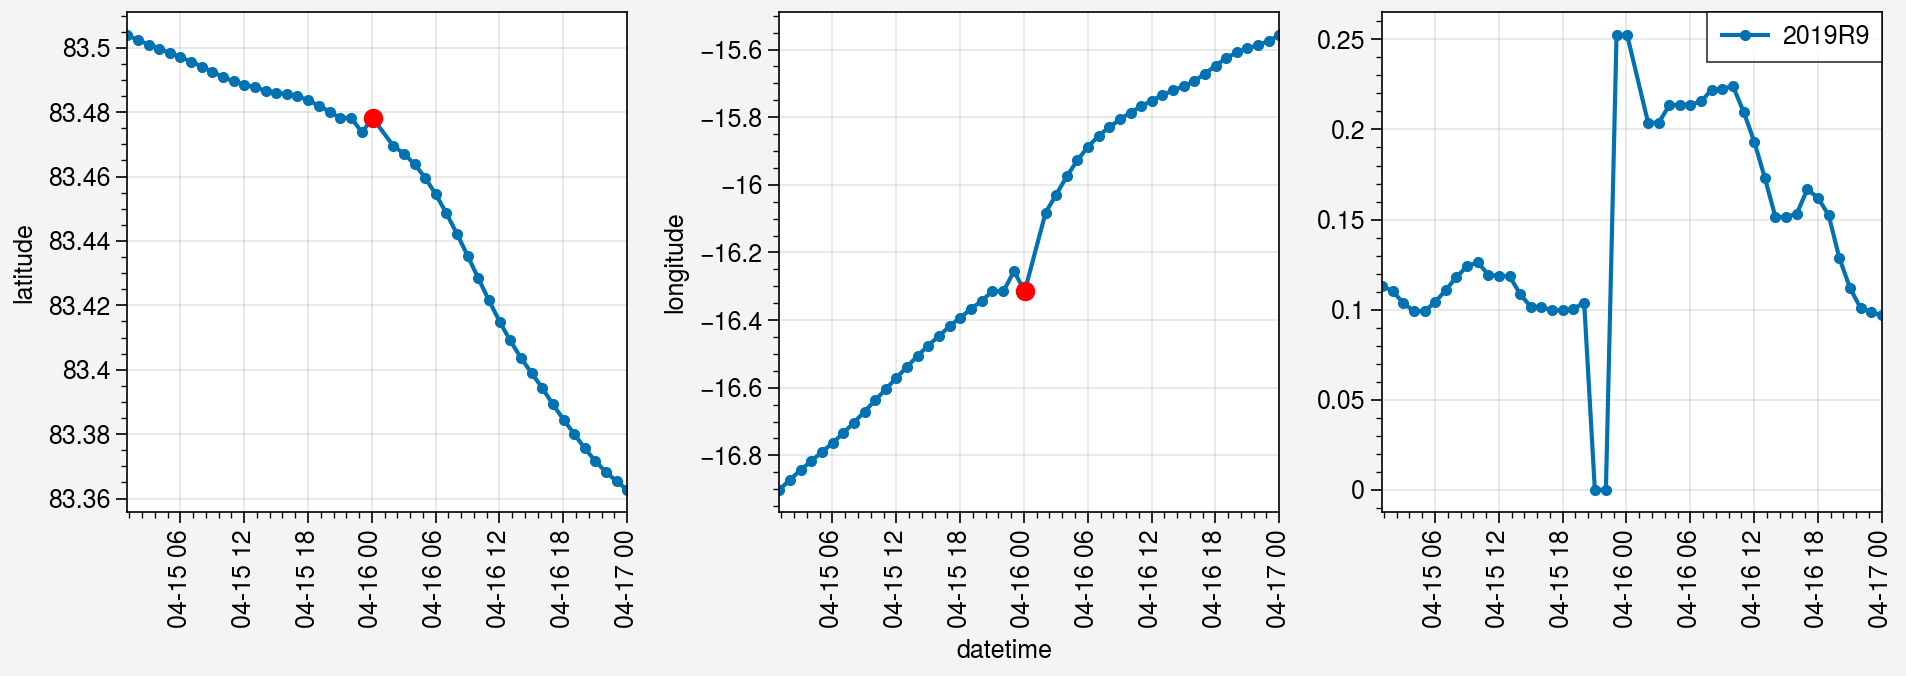

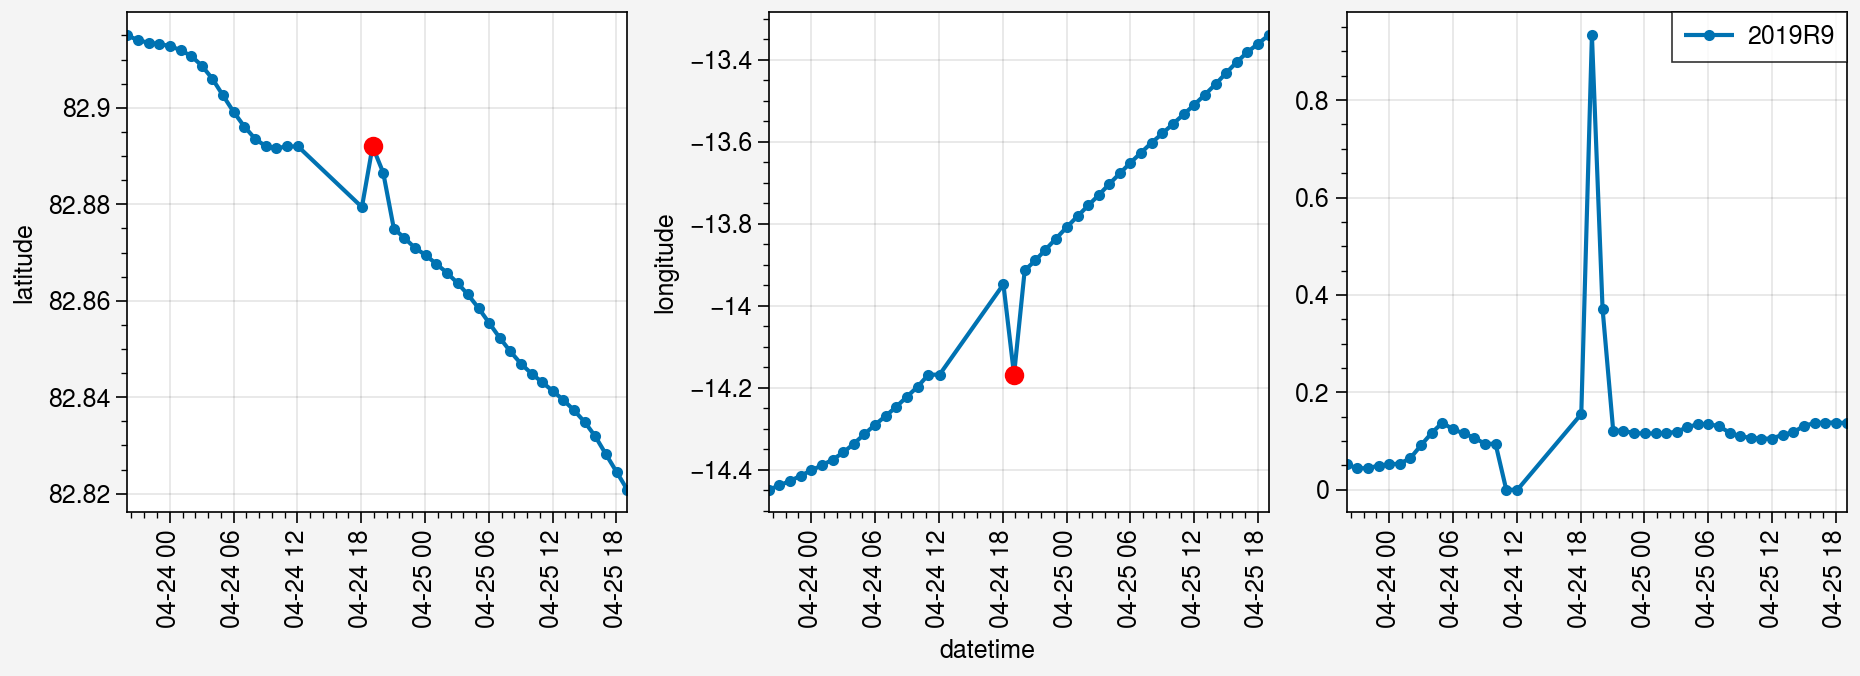

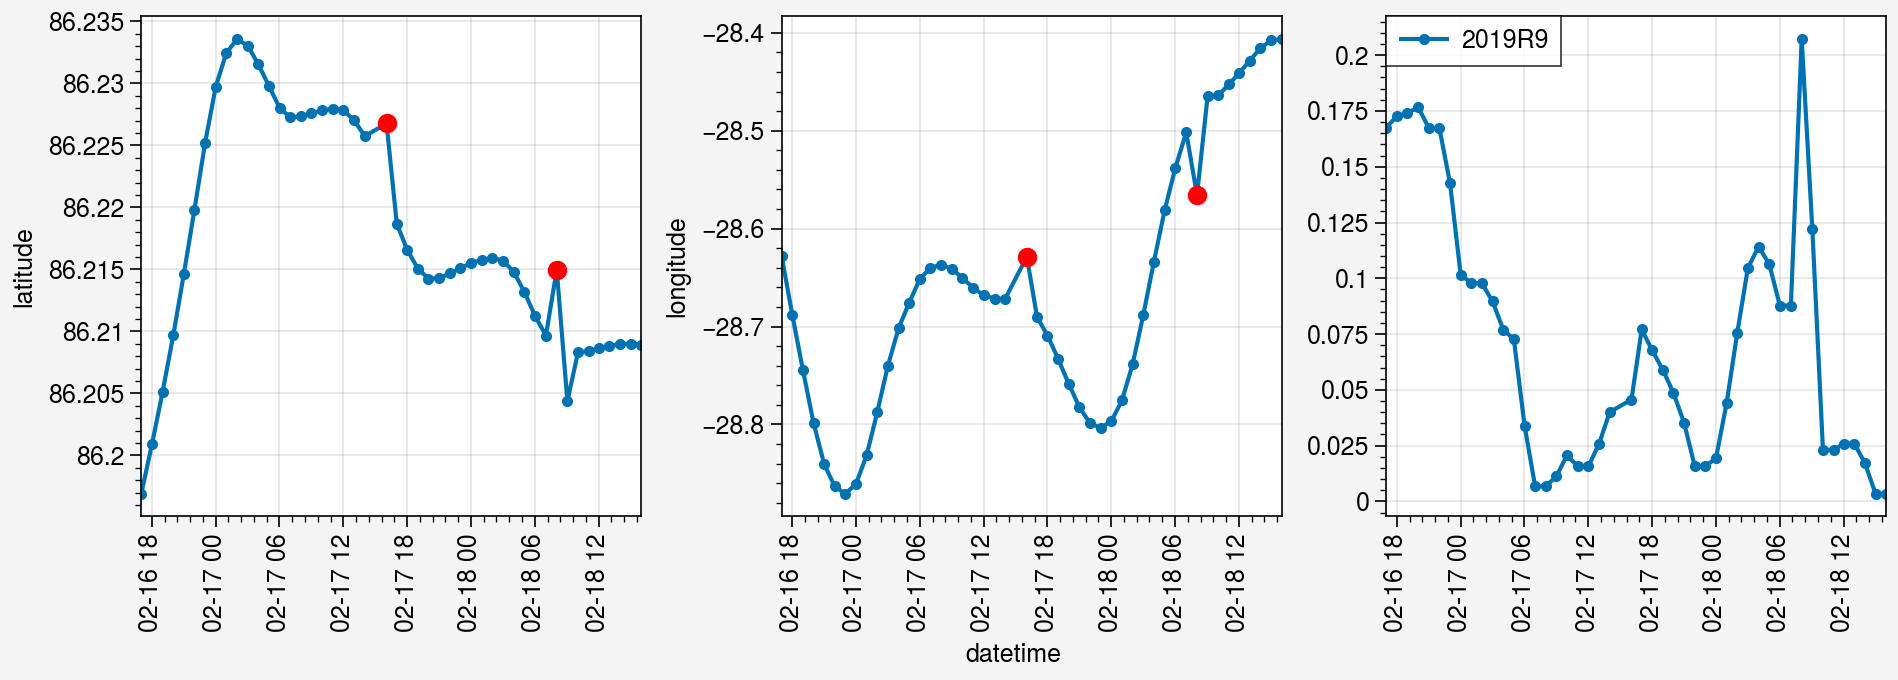

In [305]:
margin = pd.to_timedelta('24H')
#buoy_df = buoy_data[buoy]
fwd_speed = clean.compute_speed(buoy_df.copy(), date_index=True, difference='forward')['speed']   
bwd_speed = clean.compute_speed(buoy_df.copy(), date_index=True, difference='backward')['speed']   
speed = pd.DataFrame({'b': bwd_speed, 'f': fwd_speed}).min(axis=1)

fwd_speed2 = clean.compute_speed(buoy_df2.copy(), date_index=True, difference='forward')['speed']   
bwd_speed2 = clean.compute_speed(buoy_df2.copy(), date_index=True, difference='backward')['speed']   
speed2 = pd.DataFrame({'b': bwd_speed2, 'f': fwd_speed2}).min(axis=1)

for date in buoy_df.loc[test==1].index:
    fig, ax = pplt.subplots(ncols=3, sharey=False)
    for axis, var in zip(ax, ['latitude', 'longitude']):
        data = buoy_df.loc[slice(date - margin, date + margin)]
        axis.plot(data[var], marker='.')
        axis.plot(data[var].where(data['spline_tool']), marker='o', color='r', lw=0)

    
    ax[2].plot(speed[slice(date - margin, date + margin)], marker='.', label='2019R9')
#ax[2].plot(speed2[slice(date - margin, date + margin)], marker='.', label='2019S93')
    ax[2].legend(ncols=1)
    
for date in list(buoy_df.loc[test2[test2==1].index].index):
    fig, ax = pplt.subplots(ncols=3, sharey=False)
    for axis, var in zip(ax, ['latitude', 'longitude']):
        data = buoy_df.loc[slice(date - margin, date + margin)]
        axis.plot(data[var], marker='.')
        axis.plot(data[var].where(data['spline_tool']), marker='o', color='r', lw=0)
    
    ax[2].plot(speed[slice(date - margin, date + margin)], marker='.', label='2019R9')
#ax[2].plot(speed2[slice(date - margin, date + margin)], marker='.', label='2019S93')
    ax[2].legend(ncols=1)

In [301]:
buoy_df['spline_tool'].sum()

9